# Grover's search for D-optimal sequences

In [1]:
import matplotlib
from matplotlib import cm
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib notebook
%config InlineBackend.figure_formats = {'png', 'retina'}
matplotlib.rcParams['figure.figsize'] = (8.0, 5.0)

from quantum import *
from math import log, ceil, floor
from lib import paf, psd


# search for D-optimal sequences length=3
seq_len = 5

In [2]:
def equal(a, b):
    EPSILON = 0.00001
    return abs(a - b) < EPSILON


def is_d_optimal(A, B):
    # check PAF invariant
    for s in range(1, (seq_len//2)+1):
        if paf(A, s) + paf(B, s) != 2: return False
    return True


def bits_to_seq(bitstring):
    return [-1 if i == '0' else 1 for i in bitstring]


def irange(start, end):
    return range(start, end+1)


def int_to_seq_pair(bitstring):
    bitmask = (2 ** seq_len) - 1 # 111...1 (length = N)
    # get first half of bitstring
    first_half = (bitstring >> seq_len) & bitmask
    # get second half
    second_half = bitstring & bitmask
    seq_A = bits_to_seq("{:0{width}b}".format(first_half, width=seq_len))
    seq_B = bits_to_seq("{:0{width}b}".format(second_half, width=seq_len))
    return (seq_A, seq_B)


def bitwise_and(integer):
    """
    Performs AND on each individual bit of the binary representation of `integer`
    """
    if integer == 0: return 0
    result = 1
    for i in range(int(log(integer, 2))):
        bitmask = 0b1 << i
        bit = (integer & bitmask) >> i
        result = result & bit
    return result


def is_bitstring_doptimal(integer):
    """
    Returns whether the given input is a binary encoding of two sequences that
    are mutually D-optimal.
    
    :param: bitstring (int) length = seq_len
    :returns: (bool)
    """
    A, B = int_to_seq_pair(integer)
    m = (seq_len - 1) // 2
    pafs = (paf(A, s) + paf(B, s) for s in irange(1, m))
    # PAF(A,s) + PAF(B,s) = 4k + 2   (for int k, for s = 1..m)
    # PAF(A,s) + PAF(B,s) = 2        (for A,B D-optimal)
    # subtract 2 (so that =0 for D-opt) and square to make non-negative
    S = sum((p - 2)**2 for p in pafs)
    # now we have a positive integer for non-D-optimal pairs
    # NOT then bitwise AND yields 1 if we had 0 (D-opt), otherwise yields 0
    x = np.uint32(S**2)
    return bitwise_and(~x)

In [3]:
all_bitstrings = range(2**(2*seq_len))
dopt_bitstrings = [bits for bits in all_bitstrings if is_bitstring_doptimal(bits)]
print('found {} out of {} d-optimal sequence pairs'.format(len(dopt_bitstrings), len(all_bitstrings)))
print(', '.join(str(b) for b in dopt_bitstrings))

found 100 out of 1024 d-optimal sequence pairs
33, 34, 36, 40, 47, 48, 55, 59, 61, 62, 65, 66, 68, 72, 79, 80, 87, 91, 93, 94, 129, 130, 132, 136, 143, 144, 151, 155, 157, 158, 257, 258, 260, 264, 271, 272, 279, 283, 285, 286, 481, 482, 484, 488, 495, 496, 503, 507, 509, 510, 513, 514, 516, 520, 527, 528, 535, 539, 541, 542, 737, 738, 740, 744, 751, 752, 759, 763, 765, 766, 865, 866, 868, 872, 879, 880, 887, 891, 893, 894, 929, 930, 932, 936, 943, 944, 951, 955, 957, 958, 961, 962, 964, 968, 975, 976, 983, 987, 989, 990


sequence length: 5
qubits: 10
search space: 1024
recall that the d-optimal bitstrings are
33, 34, 36, 40, 47, 48, 55, 59, 61, 62, 65, 66, 68, 72, 79, 80, 87, 91, 93, 94, 129, 130, 132, 136, 143, 144, 151, 155, 157, 158, 257, 258, 260, 264, 271, 272, 279, 283, 285, 286, 481, 482, 484, 488, 495, 496, 503, 507, 509, 510, 513, 514, 516, 520, 527, 528, 535, 539, 541, 542, 737, 738, 740, 744, 751, 752, 759, 763, 765, 766, 865, 866, 868, 872, 879, 880, 887, 891, 893, 894, 929, 930, 932, 936, 943, 944, 951, 955, 957, 958, 961, 962, 964, 968, 975, 976, 983, 987, 989, 990

peak probability: 1.000%
significant qubit probabilities
 33 (00000100001)    1.000%
 34 (00000100010)    1.000%
 36 (00000100100)    1.000%
 40 (00000101000)    1.000%
 47 (00000101111)    1.000%
 48 (00000110000)    1.000%
 55 (00000110111)    1.000%
 59 (00000111011)    1.000%
 61 (00000111101)    1.000%
 62 (00000111110)    1.000%
 65 (00001000001)    1.000%
 66 (00001000010)    1.000%
 68 (00001000100)    1.000%
 72 (0000

<IPython.core.display.Javascript object>


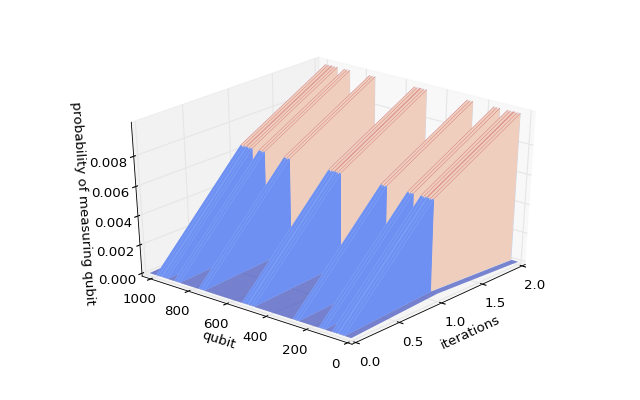

In [4]:
def grovers_plot(func, qubits, N=None, iterations=None):    
    if N is None:
        N = 2 ** qubits

    # input: |00...0> (length n)
    # output: |0>
    state = Q(kron(*(zero for _ in range(qubits)), zero))

    # Apply HX to the output register.
    state = state.apply_gate(X, 0)
    state = state.apply_gate(H, 0)

    # Apply H^n to the input register.
    # input register: qubits 1 to n
    input_H = kron(*(H for _ in range(qubits)), I)
    state = state.apply_unitary(input_H)

    # First, we'll compute the diffusion operator.
    # this definition of D (the diffusion matrix aka. inversion about the mean)
    # is given in Grover's original paper
    P = 1/N * np.ones((N, N))
    D = kron(-np.eye(N) + 2*P, I)
    
    if iterations is None:
        iterations = floor((np.pi/4) * sqrt(N).real)
        
    zgrid = np.zeros((iterations+1, 2**qubits))

    np.set_printoptions(precision=2)
    
    # Now we perform the Grover iteration.
    for iteration in range(1, iterations+1):
        state = state.apply_func(func)
        state = state.apply_unitary(D)
        amplitudes = to_row(state.state)
        probs = [(abs(a) ** 2).real for a in amplitudes]
        
        for qubit, prob in enumerate(probs):
            bitstring = qubit >> 1
            zgrid[iteration][bitstring] += prob
            
    print("peak probability: {:.3f}%".format(100*zgrid.max()))
    
    print("significant qubit probabilities")
    amplitudes = to_row(state.state)
    probs = [(abs(a) ** 2).real for a in amplitudes]
    bitstrings = {}
    for qubit, prob in enumerate(probs):
        bitstring = qubit >> 1 # chop off output register
        bitstrings[bitstring] = bitstrings.get(bitstring, 0) + prob
    for bitstring, prob in bitstrings.items():
        if prob < 0.0001: continue
        print("{0:3} ({0:0{width}b})  {1:7.3f}%".format(bitstring, 100*prob, width=2*seq_len+1))
    

    ax = plt.axes(projection='3d')
    ax.set_xlabel('iterations')
    ax.set_ylabel('qubit')
    ax.set_zlabel('probability of measuring qubit')
    ax.set_xlim(0, iterations)
    ax.set_ylim(0, 2**qubits)
    ax.set_zlim(0.0, zgrid.max())
    
    xscale = list(range(iterations+1))
    yscale = list(range(2**qubits))
    xmesh, ymesh = np.meshgrid(xscale, yscale)
    ax.plot_surface(xmesh.T, ymesh.T, zgrid, rstride=1, cstride=1, cmap=cm.coolwarm, linewidth=0)

# we need 2 * N qubits to search through sequence pairs
qubits = seq_len * 2
space_size = 2 ** qubits

print('sequence length:', seq_len)
print('qubits:', qubits)
print('search space:', space_size)

print("recall that the d-optimal bitstrings are")
print(', '.join(str(b) for b in dopt_bitstrings))
print()
    
def func(x):
    return 1 if is_bitstring_doptimal(x) else 0
    
grovers_plot(func, qubits=qubits, iterations = 2)